# Figuring out the SDSS imaging pipeline 
to better understand observations and trying to be an astronomer...

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
% matplotlib inline 

from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
from ChangTools.fitstables import mrdfits

In [2]:
from pydl.pydlutils.spheregroup import spherematch

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
# some constants
lsun = 3.846e33
pc = 3.085677581467e18 # cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.*np.pi * (pc * 10)**2)

## iSEDfit catalog

In [4]:
isedfit = mrdfits('../local/iGalPros/NSA_iSEDfit/nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz')

In [5]:
print sorted(isedfit.__dict__.keys())

['age', 'age_50', 'age_avg', 'age_err', 'av', 'av_50', 'av_avg', 'av_err', 'b100', 'b1000', 'b1000_50', 'b1000_avg', 'b1000_err', 'b100_50', 'b100_avg', 'b100_err', 'bestmaggies', 'bursttype', 'chi2', 'chunkindx', 'dec', 'delayed', 'dtburst', 'ewniiha', 'ewniiha_50', 'ewniiha_avg', 'ewniiha_err', 'ewoii', 'ewoii_50', 'ewoii_avg', 'ewoii_err', 'ewoiiihb', 'ewoiiihb_50', 'ewoiiihb_avg', 'ewoiiihb_err', 'fburst', 'isedfit_id', 'ivarmaggies', 'maggies', 'modelindx', 'mstar', 'mstar_50', 'mstar_avg', 'mstar_err', 'mu', 'mu_50', 'mu_avg', 'mu_err', 'nburst', 'nlyc', 'oiiihb', 'oiiihb_50', 'oiiihb_avg', 'oiiihb_err', 'ra', 'sfr', 'sfr100', 'sfr100_50', 'sfr100_avg', 'sfr100_err', 'sfr_50', 'sfr_avg', 'sfr_err', 'sfrage', 'sfrage_50', 'sfrage_avg', 'sfrage_err', 'tau', 'tau_50', 'tau_avg', 'tau_err', 'tburst', 'totalmass', 'totalmass_err', 'trunctau', 'z', 'zmetal', 'zmetal_50', 'zmetal_avg', 'zmetal_err']


## NSA catalog

In [6]:
nsa = mrdfits('../local/iGalPros/catalogs/nsa_v0_1_2.fits')
print sorted(nsa.__dict__.keys())

['absmag', 'ahdew', 'ahdewerr', 'ahgew', 'ahgewerr', 'aid', 'amivar', 'asymmetry', 'av', 'b1000', 'b300', 'ba50', 'ba90', 'bastokes', 'camcol', 'clumpy', 'coeff', 'd4000', 'd4000err', 'dec', 'deccat', 'dflags', 'dversion', 'extinction', 'fa', 'faerr', 'fiberflux', 'fiberflux_ivar', 'fiberid', 'field', 'haew', 'haewerr', 'haflux', 'hafluxerr', 'havmeas', 'havmerr', 'hbew', 'hbewerr', 'hbflux', 'hbfluxerr', 'hbvmeas', 'hbvmerr', 'ialfalfa', 'iauname', 'ined', 'isdss', 'isixdf', 'itwodf', 'izcat', 'kcoeff', 'kcorrect', 'mag', 'mass', 'mets', 'mjd', 'mtol', 'n2ew', 'n2ewerr', 'n2flux', 'n2fluxerr', 'n2vmeas', 'n2vmerr', 'ne3ew', 'ne3ewerr', 'ne5ew', 'ne5ewerr', 'nmgy', 'nmgy_ivar', 'nprof', 'nsaid', 'o1ew', 'o1ewerr', 'o1flux', 'o1fluxerr', 'o1vmeas', 'o1vmerr', 'o2ew', 'o2ewerr', 'o2flux', 'o2fluxerr', 'o2vmeas', 'o2vmerr', 'o3ew', 'o3ewerr', 'o3flux', 'o3fluxerr', 'o3vmeas', 'o3vmerr', 'objno', 'ok', 'petroflux', 'petroflux_ivar', 'petroth50', 'petroth90', 'petrotheta', 'phi50', 'phi90',

## Question 1: 
How are the maggies from iSEDfit processed from VAGC? We care because iSEDfit maggies are what's used by iSEDfit to fit photometry. 

Here's how we're going to answer this question, 
- Randomly select iSEDfit galaxies
- Cross-match them in VAGc
- Put VAGC photometry into expected pipeline
- Compare output from pipeline to iSEDfit maggies

In [7]:
# Random iSEDfit galaxies
ised_ids = random.sample(range(len(isedfit.isedfit_id)), 10)
print ised_ids 

ised_gals = [{} for i in range(len(ised_ids))]
for i, gal_dict in enumerate(ised_gals): 
    for key in isedfit.__dict__.keys(): 
        gal_dict[key] = getattr(isedfit, key)[ised_ids[i]]

[111482, 81249, 130018, 4513, 116018, 68022, 87820, 12315, 122247, 115233]


In [8]:
# cross-match using spherematch onto NSA catalog
match_nsa = spherematch(nsa.ra, nsa.dec, # NSA catalog
                        np.array([gd['ra'] for gd in ised_gals]), np.array([gd['dec'] for gd in ised_gals]),  # random galaxies
                        0.000833333) # 3 arcsec

In [9]:
# store cross-matched NSA data onto ised dictionary
for i, gal_dict in enumerate(ised_gals): 
    nsa_dict = {} 
    for key in nsa.__dict__.keys(): 
        nsa_dict[key] = getattr(nsa, key)[match_nsa[0][list(match_nsa[1]).index(i)]]
    
    gal_dict['nsa_dict'] = nsa_dict

In [10]:
for i_gal in range(len(ised_gals)): 
    print 'maggies used in iSEDfit: (nMgy)'
    print ised_gals[i_gal]['maggies'][2:]*1e9
    print 'fluxes from NSA...'
    print '      nmgy ', ised_gals[i_gal]['nsa_dict']['nmgy'][2:]
    for key in ised_gals[i_gal]['nsa_dict'].keys(): 
        if key in ['sersicflux', 'fiberflux', 'petroflux']: 
            print '      ', key,' ', ised_gals[i_gal]['nsa_dict'][key][2:]
    print '================================================='

maggies used in iSEDfit: (nMgy)
[  40.05848312   80.88079834  109.02806091  132.96569824  150.78868103]
fluxes from NSA...
      nmgy  [  40.05848312   80.88079834  109.02806091  132.96569824  150.78868103]
       sersicflux   [  31.2616787    69.82472992   98.12001038  125.08132172  147.09757996]
       fiberflux   [ 17.09338379  38.314785    54.50465012  70.11217499  82.61520386]
       petroflux   [  30.79945946   67.07176208   93.13910675  118.80628967  141.30180359]
maggies used in iSEDfit: (nMgy)
[  221.81326294  1335.22583008  2849.45556641  4094.61474609  4948.07421875]
fluxes from NSA...
      nmgy  [  221.81326294  1335.22583008  2849.45556641  4094.61450195  4948.07421875]
       sersicflux   [  202.95890808  1295.87695312  2791.63330078  4107.98339844  5052.41503906]
       fiberflux   [  34.37840652  196.22851562  433.62078857  654.27984619  879.63354492]
       petroflux   [  227.79536438   983.9800415   2062.16577148  3037.92480469  4010.70336914]
maggies used in iSEDfit

### maggies used in iSEDfit == NSA_data['nmgy']

## Question 2: 
How do the fiber fluxes compare to the AB fluxes

In [11]:
import fsps

In [12]:
# Lambda_SDSS
sdss_bands = fsps.find_filter('sdss')
L_sdss = [fsps.get_filter(sdss_band).lambda_eff/1.e4 for sdss_band in ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']]

[ 1.23960185  1.17121375  1.12145197  1.09080517  1.06356299]
0.561635
[ 1.05725408  1.04181588  1.03015721  1.02278495  1.01610172]
0.174102
[ 1.03289473  1.02409995  1.01742196  1.013183    1.00932908]
0.164974


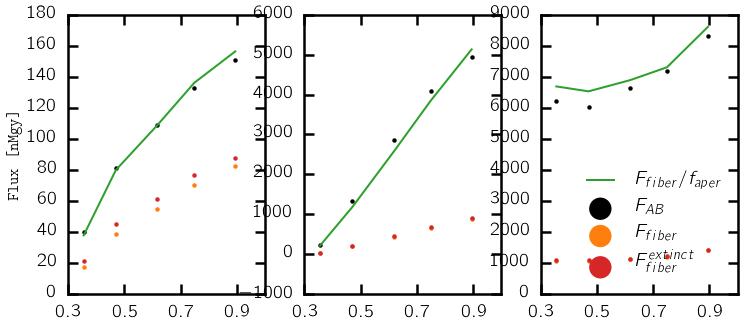

In [13]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 5))
for i_gal in range(len(ised_gals[:3])): 
    sub = fig.add_subplot(1, 3, i_gal+1)
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['nmgy'][2:], c='k', lw=0, label='$F_{AB}$')
    # fiber flux
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], c=pretty_colors[3], lw=0, label='$F_{fiber}$')

    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    print f_extinct
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct, 
                c=pretty_colors[7], lw=0, label='$F_{fiber}^{extinct}$')
    
    f_aperture =  ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    print f_aperture
    
    sub.plot(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct / f_aperture,
             c=pretty_colors[5], lw=2, label='$F_{fiber} / f_{aper}$')

    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    if i_gal == 0: 
        sub.set_ylabel('Flux [nMgy]')
sub.legend(loc='lower right', scatterpoints=1)

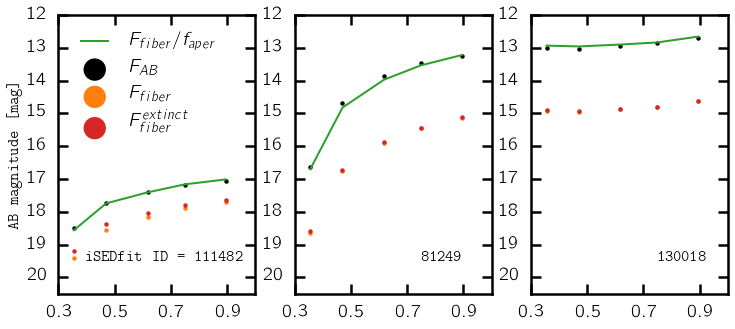

In [14]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 5))
for i_gal in range(len(ised_gals[:3])): 
    sub = fig.add_subplot(1, 3, i_gal+1)
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['nmgy'][2:]*1e-9), c='k', lw=0, label='$F_{AB}$')
    # fiber flux
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9), 
                c=pretty_colors[3], lw=0, label='$F_{fiber}$')
    
    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9 * f_extinct), 
                c=pretty_colors[7], lw=0, label='$F_{fiber}^{extinct}$')
    
    f_aperture = ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    
    sub.plot(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9 * f_extinct / f_aperture),
             c=pretty_colors[5], lw=2, label='$F_{fiber} / f_{aper}$')
    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([20.5, 12])
    if i_gal == 0: 
        sub.set_ylabel('AB magnitude [mag]')
        sub.legend(loc='upper left', scatterpoints=1)
        sub.text(0.4, 19.5, 'iSEDfit ID = '+str(ised_ids[i_gal]))
    else: 
        sub.text(0.75, 19.5, str(ised_ids[i_gal]))

## Question 3: 
How do the fiber fluxes compare to SDSS SpecObjAll spectra?

In [15]:
from ChangTools.fitstables import mrdfits
import util as UT

In [42]:
# load in galaxy spectra
for i_gal in range(len(ised_gals)): 
    if ised_gals[i_gal]['nsa_dict']['mjd'] == 0 or ised_gals[i_gal]['nsa_dict']['plate'] == 0 or ised_gals[i_gal]['nsa_dict']['fiberid'] == 0: 
        print ised_gals[i_gal]['nsa_dict']['mjd'], ised_gals[i_gal]['nsa_dict']['plate'], ised_gals[i_gal]['nsa_dict']['fiberid'] 
        ised_gals[i_gal]['lambda'] = None
        ised_gals[i_gal]['spectra_sdss'] = None
    else: 
        spec = UT.GetSpectra_SDSS(
            ised_gals[i_gal]['nsa_dict']['mjd'], 
            ised_gals[i_gal]['nsa_dict']['plate'], 
            ised_gals[i_gal]['nsa_dict']['fiberid'])
        
        ised_gals[i_gal]['lambda'] = (10**spec.loglam)/1e4
        ised_gals[i_gal]['spectra_sdss'] = spec.flux
        ised_gals[i_gal]['spectra_sdss_ivar'] = spec.ivar

0 0 0
0 0 0
0 0 0
0 0 0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


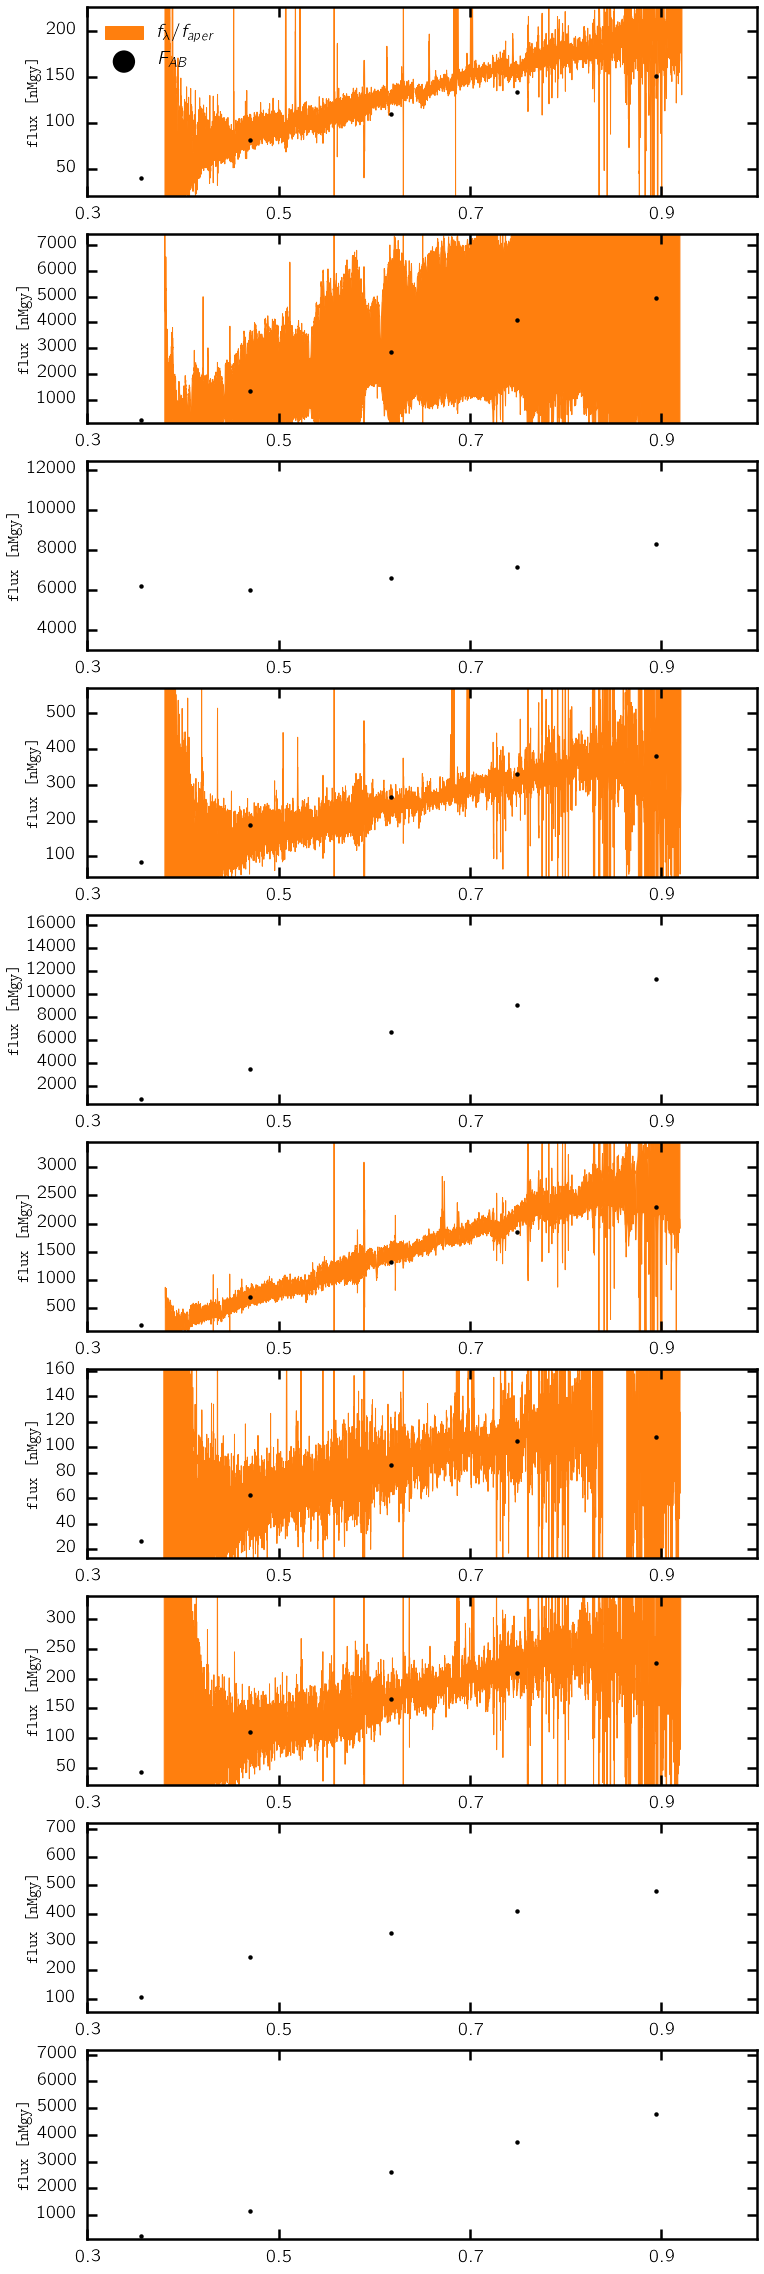

In [46]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 4*len(ised_gals)))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(len(ised_gals), 1, i_gal+1)
    # observed spectra in units of nMgys
    if ised_gals[i_gal]['spectra_sdss'] is not None:
        flux = ised_gals[i_gal]['spectra_sdss'] * (ised_gals[i_gal]['lambda'] * 1e4)**2 / lightspeed / 1e3 / (3631 * 1e-26) * 1e-17 * 1e9
        flux_err = ised_gals[i_gal]['spectra_sdss_ivar']**-2 * (ised_gals[i_gal]['lambda'] * 1e4)**2 / lightspeed / 1e3 / (3631 * 1e-26) * 1e-17 * 1e9
    
        f_aperture = ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    
        #sub.plot(ised_gals[i_gal]['lambda'], flux / f_aperture, c=pretty_colors[3], lw=1, ls='--', label='$f_\lambda / f_{aper}$')
        sub.fill_between(ised_gals[i_gal]['lambda'], (flux - flux_err) / f_aperture, (flux + flux_err) / f_aperture, 
                         color=pretty_colors[3], lw=1, label='$f_\lambda / f_{aper}$')
    
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['nmgy'][2:], c='k', lw=0, label='$F_{AB}$')

    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([0.5*ised_gals[i_gal]['nsa_dict']['nmgy'][2:].min(), 1.5*ised_gals[i_gal]['nsa_dict']['nmgy'][2:].max()])
    sub.set_ylabel('flux [nMgy]')
    if i_gal == 0: 
        sub.legend(loc='upper left', scatterpoints=1)
        #sub.text(0.4, 19.5, 'iSEDfit ID = '+str(ised_ids[i_gal]))
    else:
        pass
        #sub.text(0.75, 19.5, str(ised_ids[i_gal]))

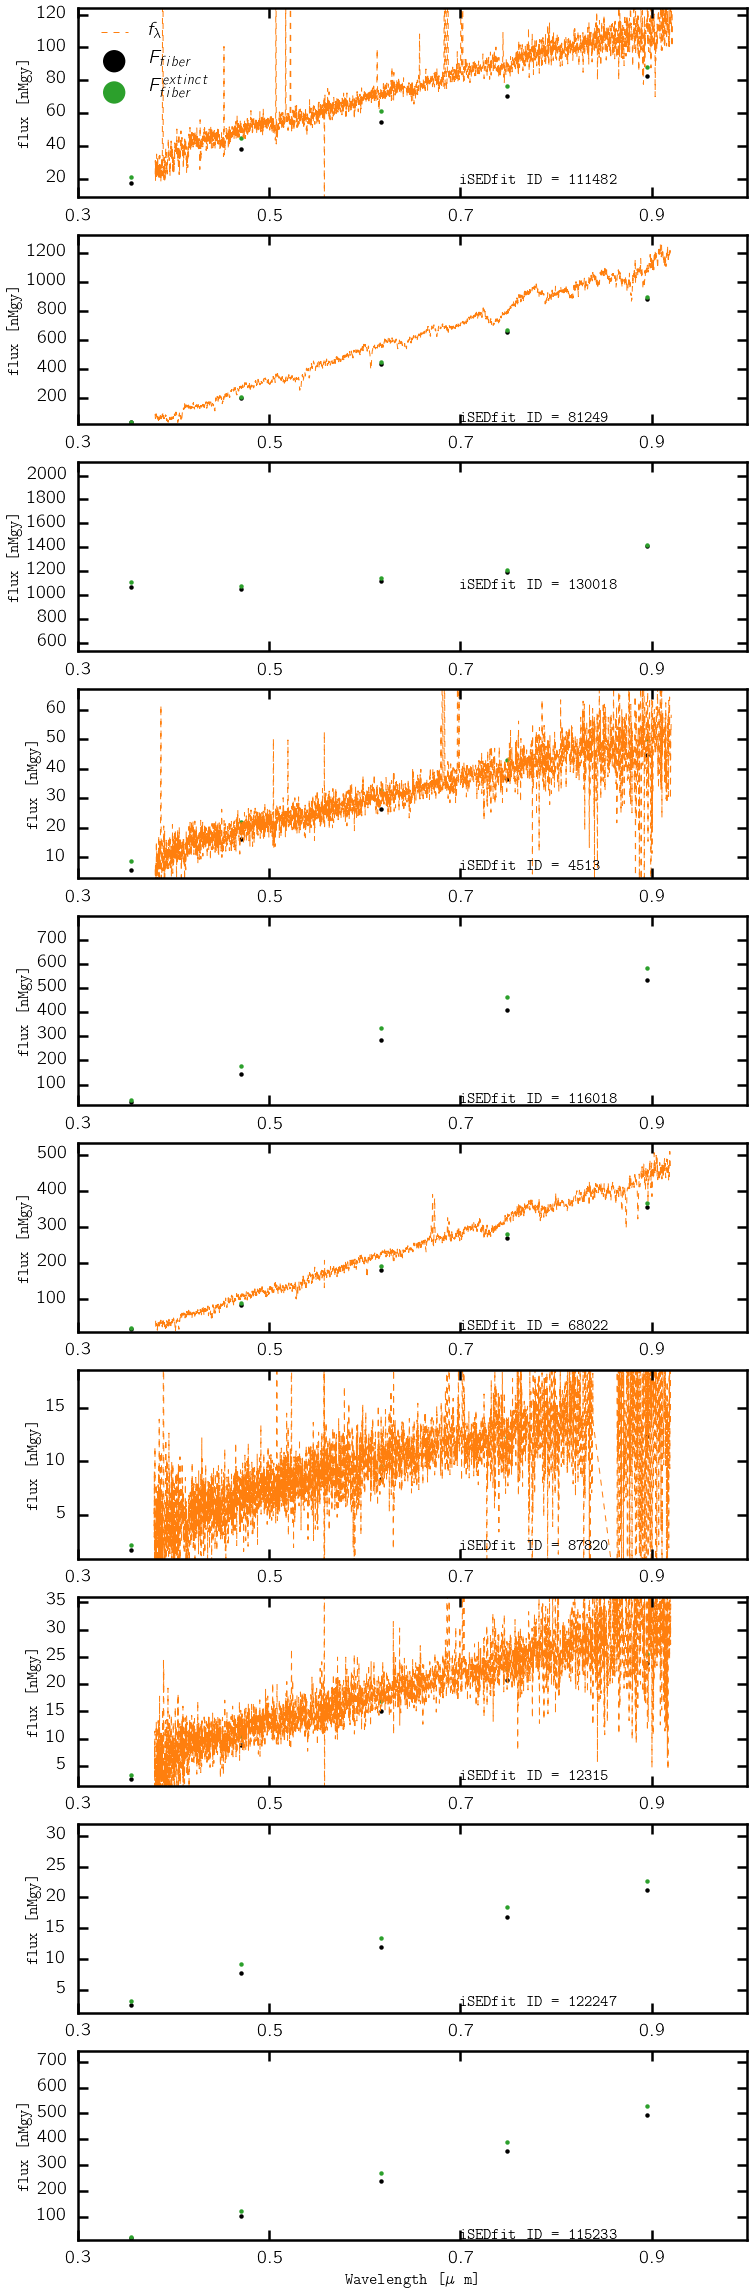

In [24]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 4*len(ised_gals)))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(len(ised_gals), 1, i_gal+1)
    # observed spectra in units of nMgys
    if ised_gals[i_gal]['spectra_sdss'] is not None: 
        flux = ised_gals[i_gal]['spectra_sdss'] * (ised_gals[i_gal]['lambda'] * 1e4)**2 / lightspeed / 1e3 / (3631 * 1e-26) * 1e-17 * 1e9
        
        sub.plot(ised_gals[i_gal]['lambda'], flux, c=pretty_colors[3], lw=1, ls='--', label='$f_\lambda$')
    
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], 
                c='k', lw=0, label='$F_{fiber}$')
    
    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct, 
                c=pretty_colors[5], lw=0, label='$F_{fiber}^{extinct}$')
    
    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([0.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 1.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].max()])
    sub.set_ylabel('flux [nMgy]')
    sub.text(0.7, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 'iSEDfit ID = '+str(ised_ids[i_gal]))
    if i_gal == 0: 
        sub.legend(loc='upper left', scatterpoints=1)
sub.set_xlabel('Wavelength [$\mu$ m]')

## Question 4: 
Do the fiber AB fluxes agree with photometry derived from the *observed* spectra?

In [26]:
from sedpy.observate import getSED
from sedpy.observate import load_filters

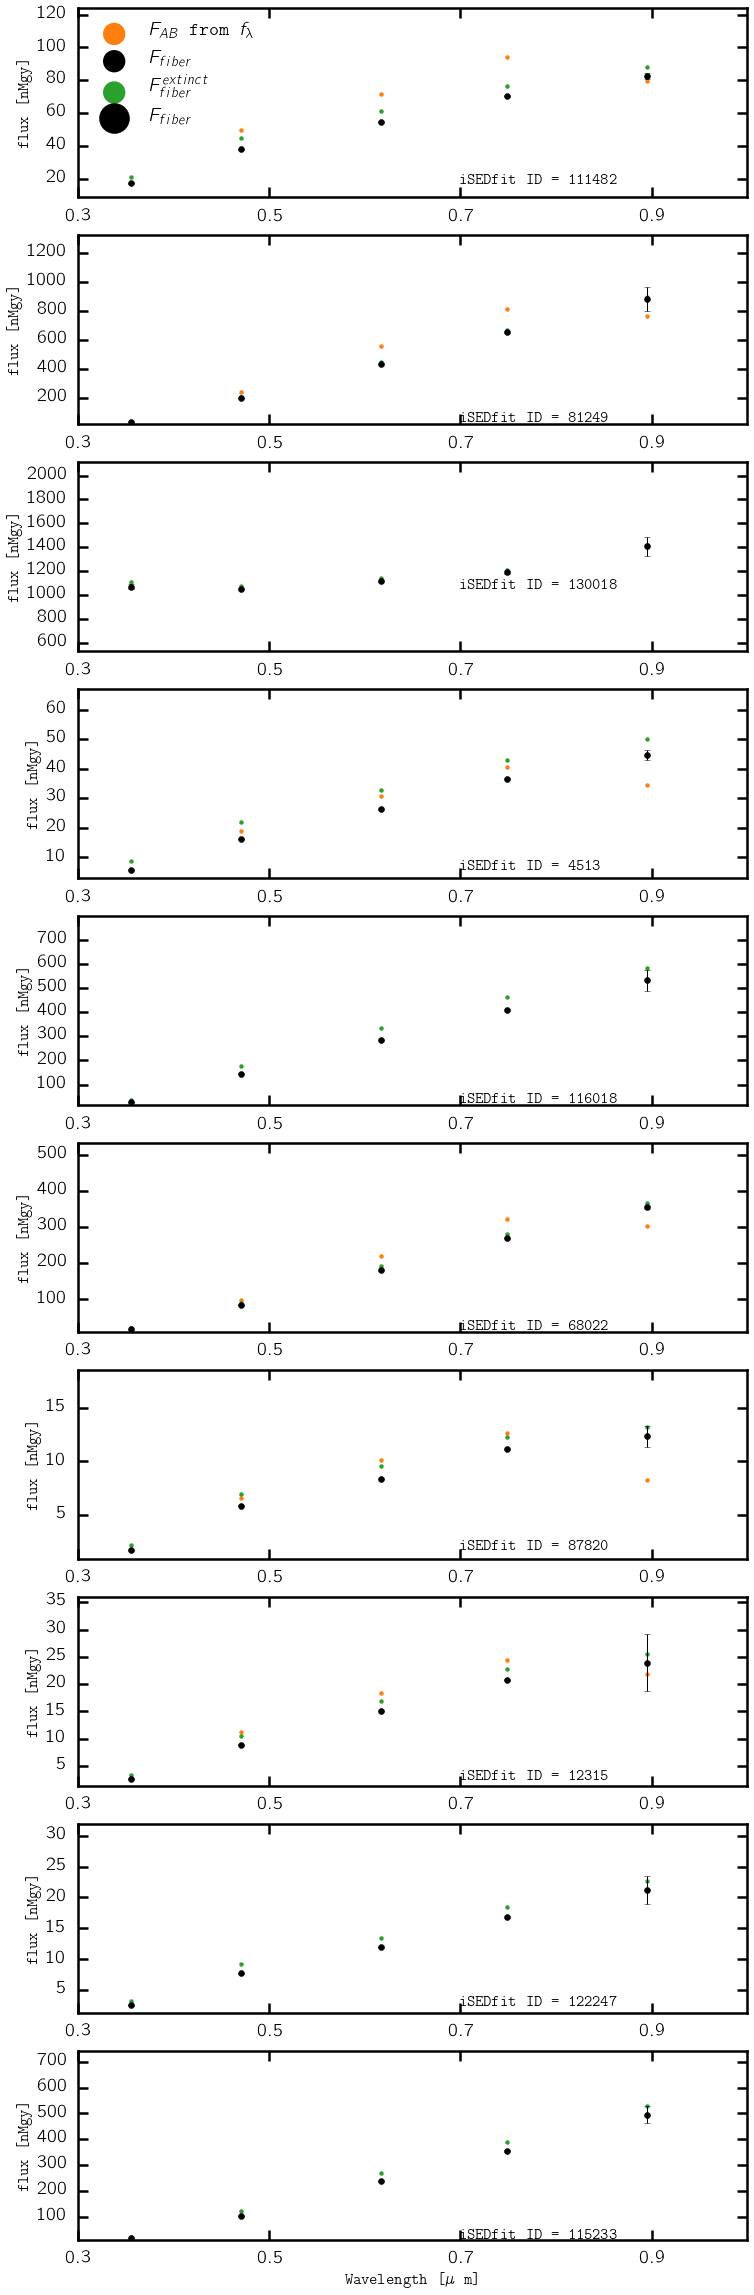

In [41]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 4*len(ised_gals)))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(len(ised_gals), 1, i_gal+1)
    # observed spectra in units of nMgys
    if ised_gals[i_gal]['spectra_sdss'] is not None: 
        flux = ised_gals[i_gal]['spectra_sdss'] * 1e-17 # cgs units
        mag_AB = getSED(ised_gals[i_gal]['lambda']*1e4, flux, 
                      filterlist=load_filters(['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']))
        sub.scatter(L_sdss, 10**(-0.4*mag_AB) * 1e9, 
                    c=pretty_colors[3], lw=0, label='$F_{AB}$ from $f_\lambda$')
    
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], 
                c='k', lw=0, label='$F_{fiber}$')
    sub.errorbar(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], yerr=(ised_gals[i_gal]['nsa_dict']['fiberflux_ivar'][2:])**-2, 
                color='k', fmt='o', label='$F_{fiber}$')
    
    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct, 
                c=pretty_colors[5], lw=0, label='$F_{fiber}^{extinct}$')
    
    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([0.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 1.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].max()])
    sub.set_ylabel('flux [nMgy]')
    sub.text(0.7, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 'iSEDfit ID = '+str(ised_ids[i_gal]))
    if i_gal == 0: 
        sub.legend(loc='upper left', scatterpoints=1, numpoints=1)
sub.set_xlabel('Wavelength [$\mu$ m]')